In [ ]:
#SET UP AND DATA ACQUISITION

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Function to get FRED data
def get_fred_data(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error retrieving data: {response.status_code} - {response.text}")
        return pd.DataFrame()

    data = response.json()
    if 'observations' not in data:
        print(f"Unexpected response format: {data}")
        return pd.DataFrame()

    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df

# Function to extract year and month
def extract_year_month(df, date_column):
    df['year_month'] = df[date_column].dt.strftime('%Y-%m')
    return df

# FRED API key
api_key = 'e27f8eae7a77b2b9d0210f2aaeda8868'

# Download S&P 500 data
spy_data = yf.download('SPY', start='2000-01-01', end='2024-10-25', interval='3mo')
spy_data.reset_index(inplace=True)
spy_data.columns = spy_data.columns.get_level_values(0)  # Flatten multi-level index
spy_data['year_month'] = spy_data['Date'].dt.strftime('%Y-%m')
spy_data['returns'] = spy_data['Adj Close'].pct_change() * 100
spy_data.dropna(subset=['returns'], inplace=True)

[*********************100%***********************]  1 of 1 completed


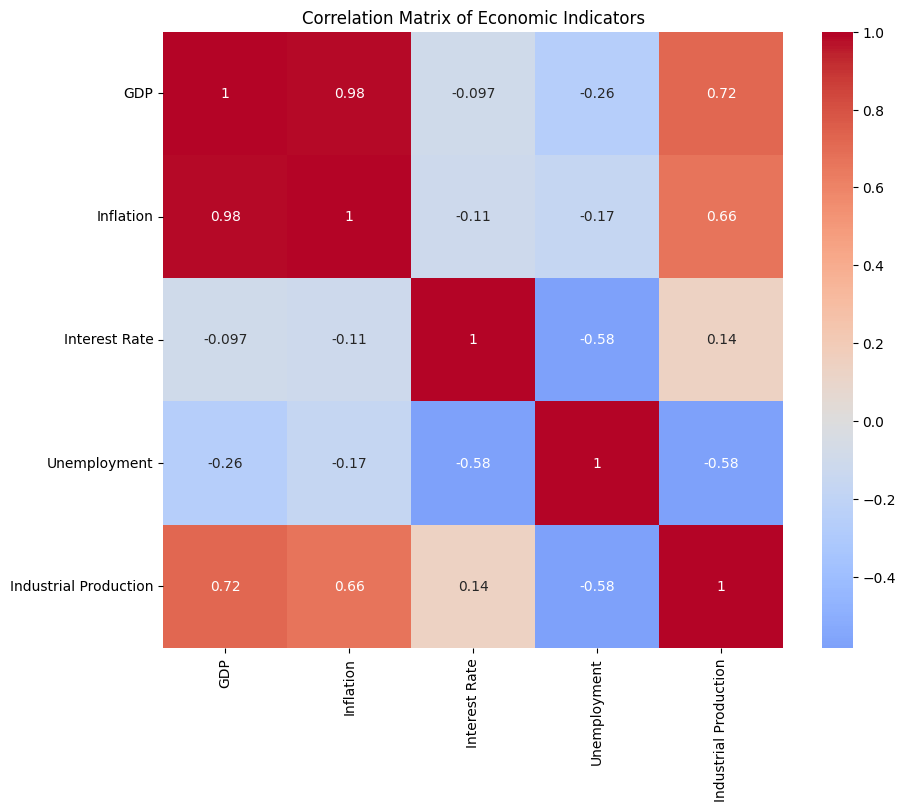

In [ ]:
#ECONOMIC INDICATORS AND CORRELATION ANALYSIS

# Retrieve economic data
gdp_data = get_fred_data('GDPC1', api_key)
inflation_data = get_fred_data('CPIAUCSL', api_key)
interest_rate_data = get_fred_data('FEDFUNDS', api_key)
unemployment_data = get_fred_data('UNRATE', api_key)
industrial_production_data = get_fred_data('INDPRO', api_key)

# Extract year and month for all datasets and filter from 2000
gdp_data = extract_year_month(gdp_data, 'date')
gdp_data = gdp_data[gdp_data['date'] >= '2000-01-01']
inflation_data = extract_year_month(inflation_data, 'date')
inflation_data = inflation_data[inflation_data['date'] >= '2000-01-01']
interest_rate_data = extract_year_month(interest_rate_data, 'date')
interest_rate_data = interest_rate_data[interest_rate_data['date'] >= '2000-01-01']
unemployment_data = extract_year_month(unemployment_data, 'date')
unemployment_data = unemployment_data[unemployment_data['date'] >= '2000-01-01']
industrial_production_data = extract_year_month(industrial_production_data, 'date')
industrial_production_data = industrial_production_data[industrial_production_data['date'] >= '2000-01-01']

# Merge all economic indicators into one DataFrame
combined_economic_data = pd.merge(gdp_data[['year_month', 'value']].rename(columns={'value': 'GDP'}),
    inflation_data[['year_month', 'value']].rename(columns={'value': 'Inflation'}), on='year_month', how='inner')
combined_economic_data = pd.merge(combined_economic_data,
    interest_rate_data[['year_month', 'value']].rename(columns={'value': 'Interest Rate'}), on='year_month', how='inner')
combined_economic_data = pd.merge(combined_economic_data,
    unemployment_data[['year_month', 'value']].rename(columns={'value': 'Unemployment'}), on='year_month', how='inner')
combined_economic_data = pd.merge(combined_economic_data,
    industrial_production_data[['year_month', 'value']].rename(columns={'value': 'Industrial Production'}), on='year_month', how='inner')

# Calculate the correlation matrix excluding non-numeric columns like 'year_month'
economic_correlation_matrix = combined_economic_data.drop(columns=['year_month']).corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(economic_correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Economic Indicators')
plt.show()


[*********************100%***********************]  1 of 1 completed


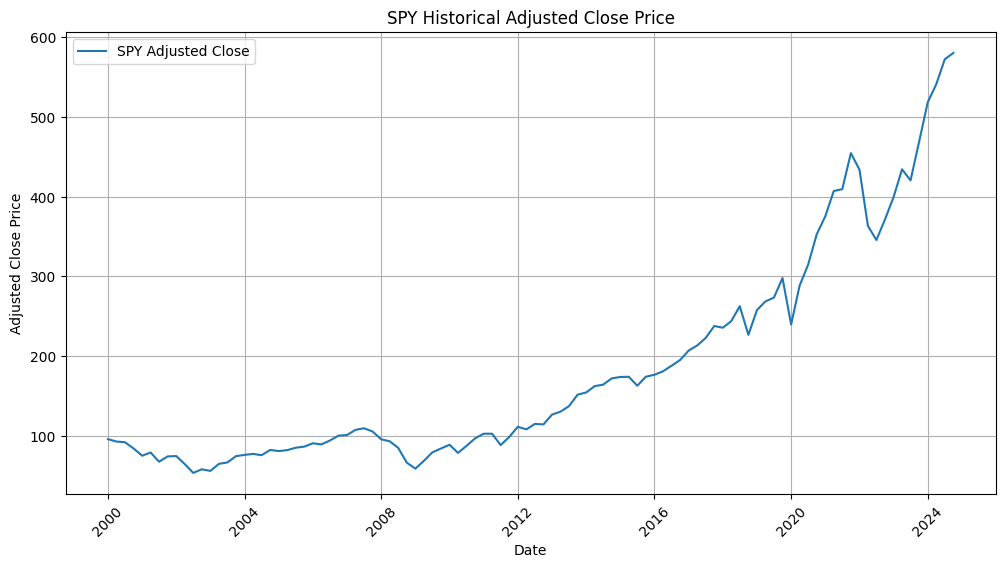

[*********************100%***********************]  1 of 1 completed


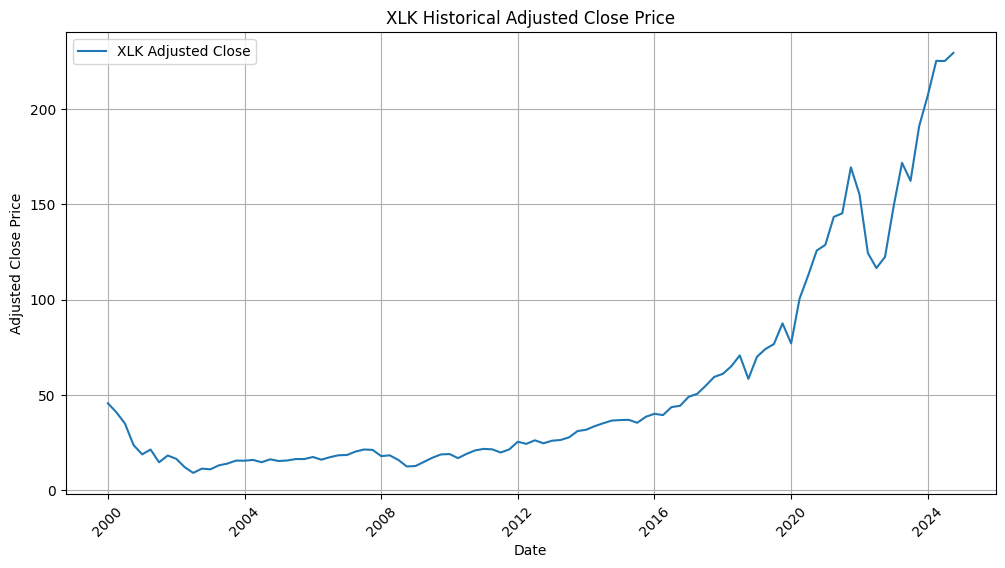

[*********************100%***********************]  1 of 1 completed


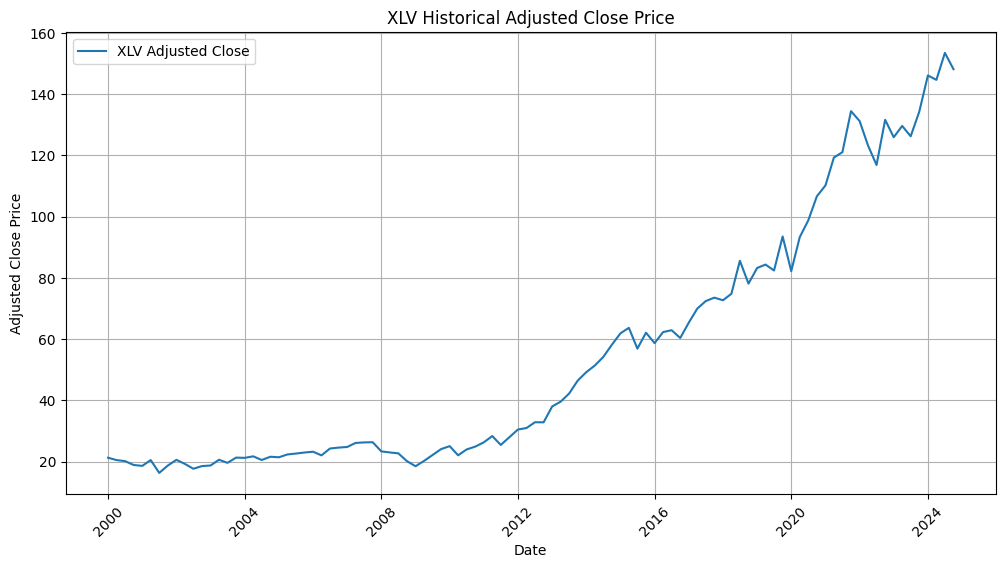

[*********************100%***********************]  1 of 1 completed


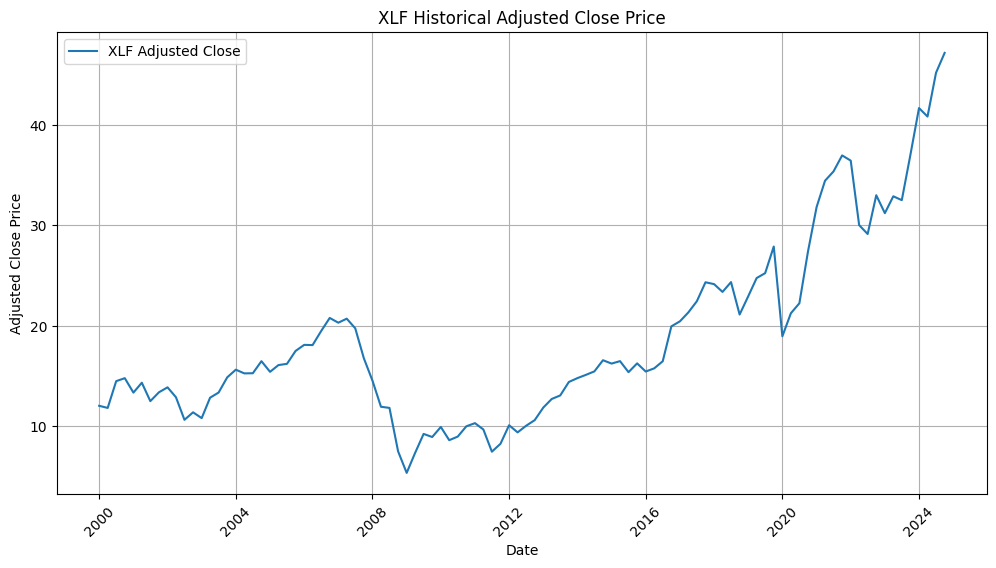

[*********************100%***********************]  1 of 1 completed


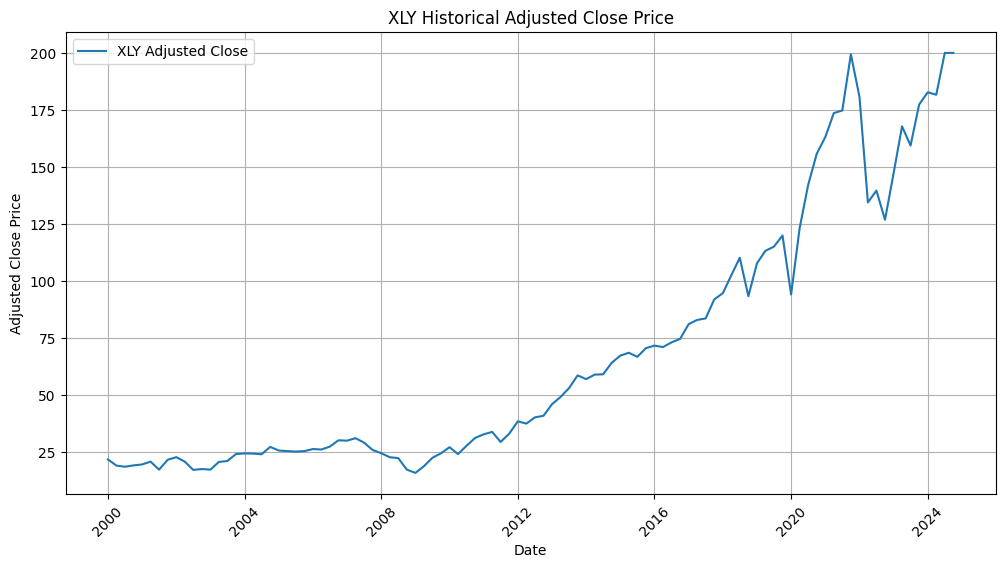

[*********************100%***********************]  1 of 1 completed


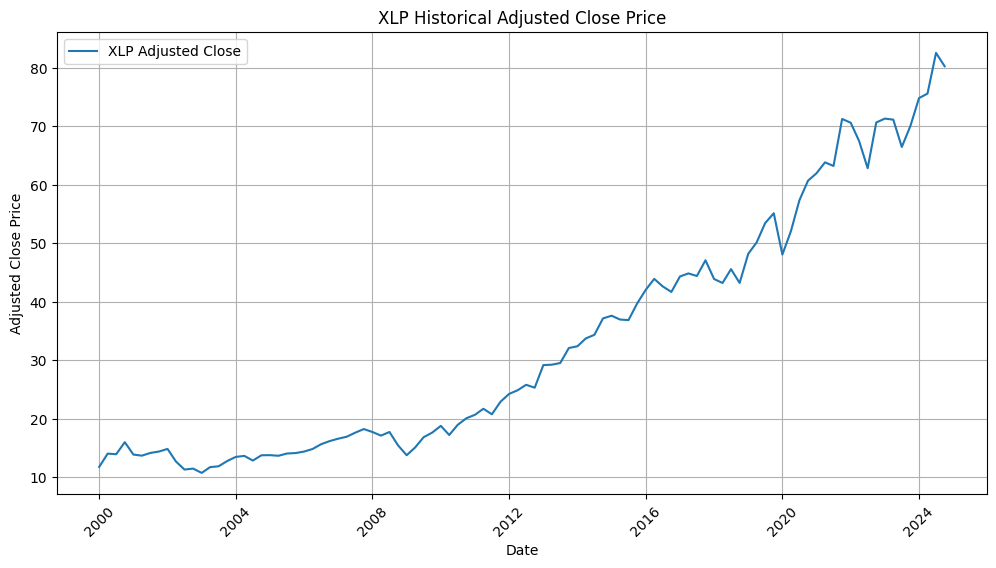

[*********************100%***********************]  1 of 1 completed


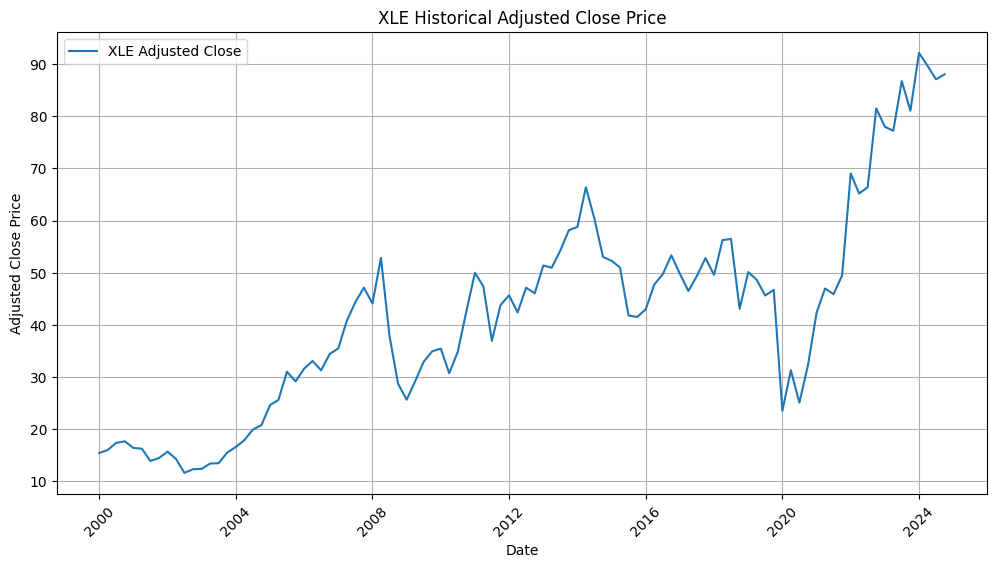

[*********************100%***********************]  1 of 1 completed


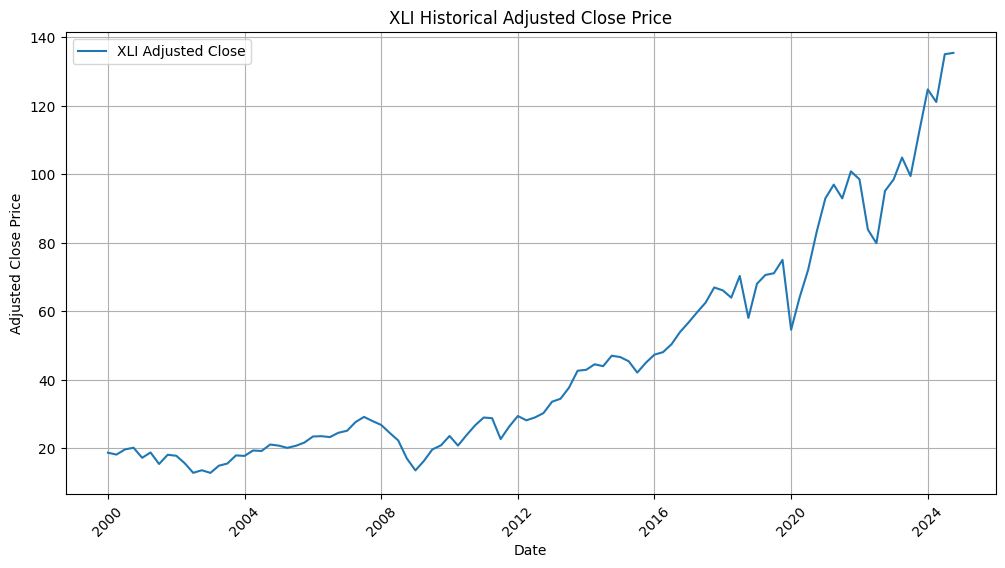

[*********************100%***********************]  1 of 1 completed


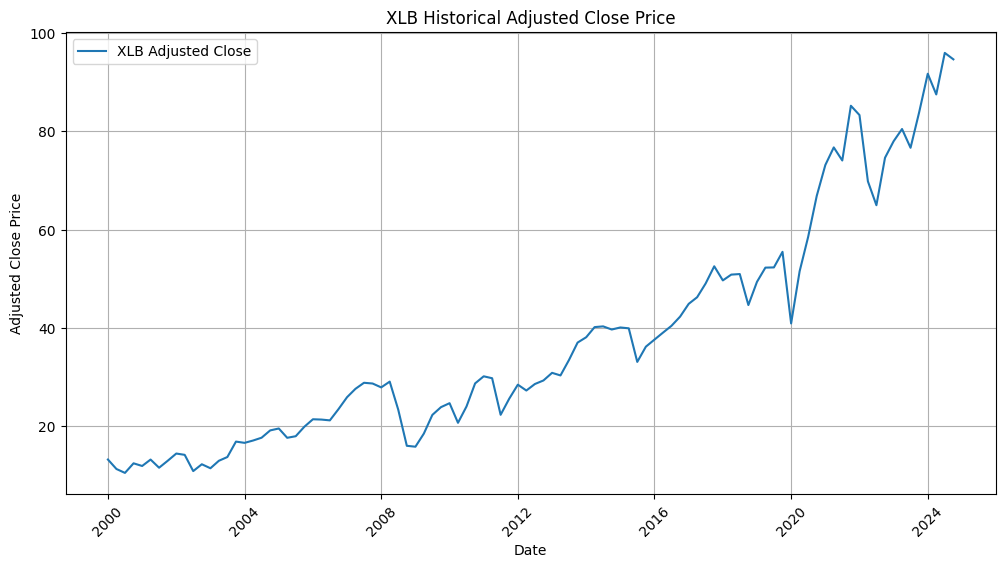

[*********************100%***********************]  1 of 1 completed


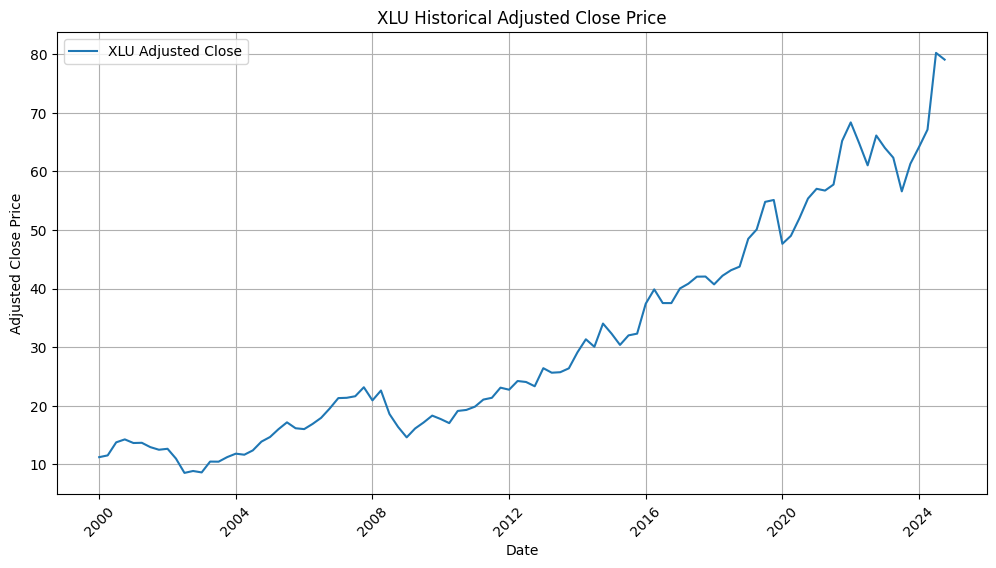

[*********************100%***********************]  1 of 1 completed


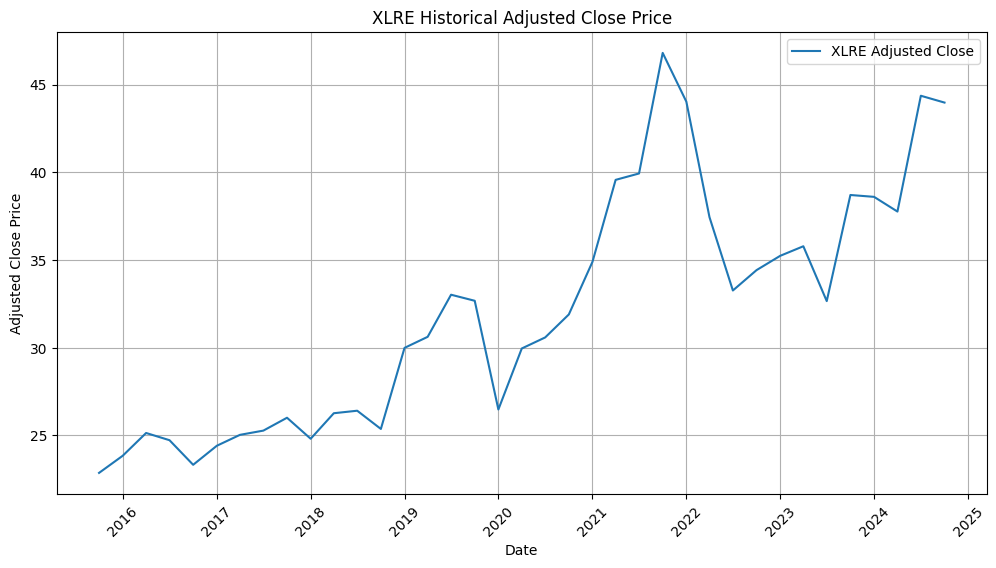

In [ ]:
#ETFS FROM YAHOO FINANCE

# List of ETFs to analyze
etfs = ["SPY", "XLK", "XLV", "XLF", "XLY", "XLP", "XLE", "XLI", "XLB", "XLU", "XLRE"]

# Download and plot data for each ETF
for etf in etfs:
    etf_data = yf.download(etf, start='2000-01-01', end='2024-10-25', interval='3mo')
    etf_data.reset_index(inplace=True)

    # Plot ETF data
    plt.figure(figsize=(12, 6))
    plt.plot(etf_data['Date'], etf_data['Adj Close'], label=f'{etf} Adjusted Close')
    plt.title(f'{etf} Historical Adjusted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

Correlation between GDP growth and SP500 returns: 0.136135580006597


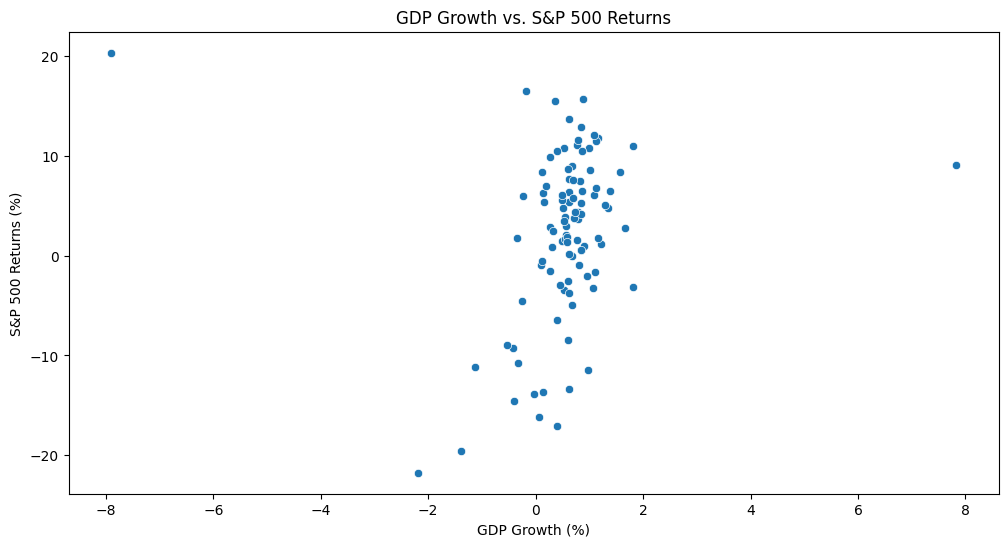

In [ ]:
#HYPOTHESIS 1: IMPACT OF ECONOMIC GROWTH ON STOCK MARKET RETURNS

# Calculate GDP growth rate
gdp_data['growth_rate'] = gdp_data['value'].pct_change() * 100

# Prepare GDP data
gdp_returns = gdp_data[['year_month', 'growth_rate']].dropna(subset=['growth_rate'])

# Merge with SPY data using the year_month column
combined_data = pd.merge(gdp_returns, spy_data, on='year_month', how='inner')

# Calculate correlation only if there is combined data
if not combined_data.empty:
    gdp_correlation = combined_data['growth_rate'].corr(combined_data['returns'])
    print("Correlation between GDP growth and SP500 returns:", gdp_correlation)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=combined_data, x='growth_rate', y='returns')
    plt.title('GDP Growth vs. S&P 500 Returns')
    plt.xlabel('GDP Growth (%)')
    plt.ylabel('S&P 500 Returns (%)')
    plt.show()
else:
    print("No overlapping data for GDP and SP500 returns.")

Correlation between inflation and SP500 returns: -0.05326088446578065


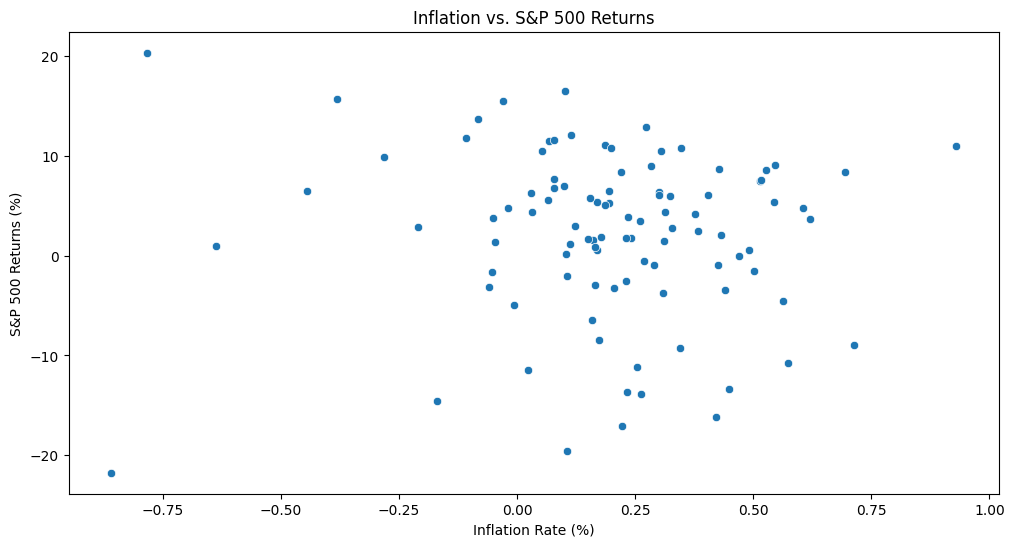

In [ ]:
#HYPOTHESIS 2: INFLATION AND STOCK MARKET VALUATION

# Calculate Inflation rate change
inflation_data['inflation_rate'] = inflation_data['value'].pct_change() * 100

# Prepare inflation data
inflation_returns = inflation_data[['year_month', 'inflation_rate']].dropna(subset=['inflation_rate'])

# Merge with SPY data using the year_month column
combined_inflation_data = pd.merge(inflation_returns, spy_data, on='year_month', how='inner')

# Calculate correlation only if there is combined data
if not combined_inflation_data.empty:
    inflation_correlation = combined_inflation_data['inflation_rate'].corr(combined_inflation_data['returns'])
    print("Correlation between inflation and SP500 returns:", inflation_correlation)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=combined_inflation_data, x='inflation_rate', y='returns')
    plt.title('Inflation vs. S&P 500 Returns')
    plt.xlabel('Inflation Rate (%)')
    plt.ylabel('S&P 500 Returns (%)')
    plt.show()
else:
    print("No overlapping data for inflation and SP500 returns.")